In [6]:
#importing all necessary modules
from keras import Sequential
from keras import layers
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
import pathlib

Paste the path to the dataset below

In [11]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("prashant268/chest-xray-covid19-pneumonia",)

100%|██████████| 2.06G/2.06G [06:00<00:00, 6.12MB/s]

Extracting files...


In [13]:
PathToDataset=pathlib.Path(path)

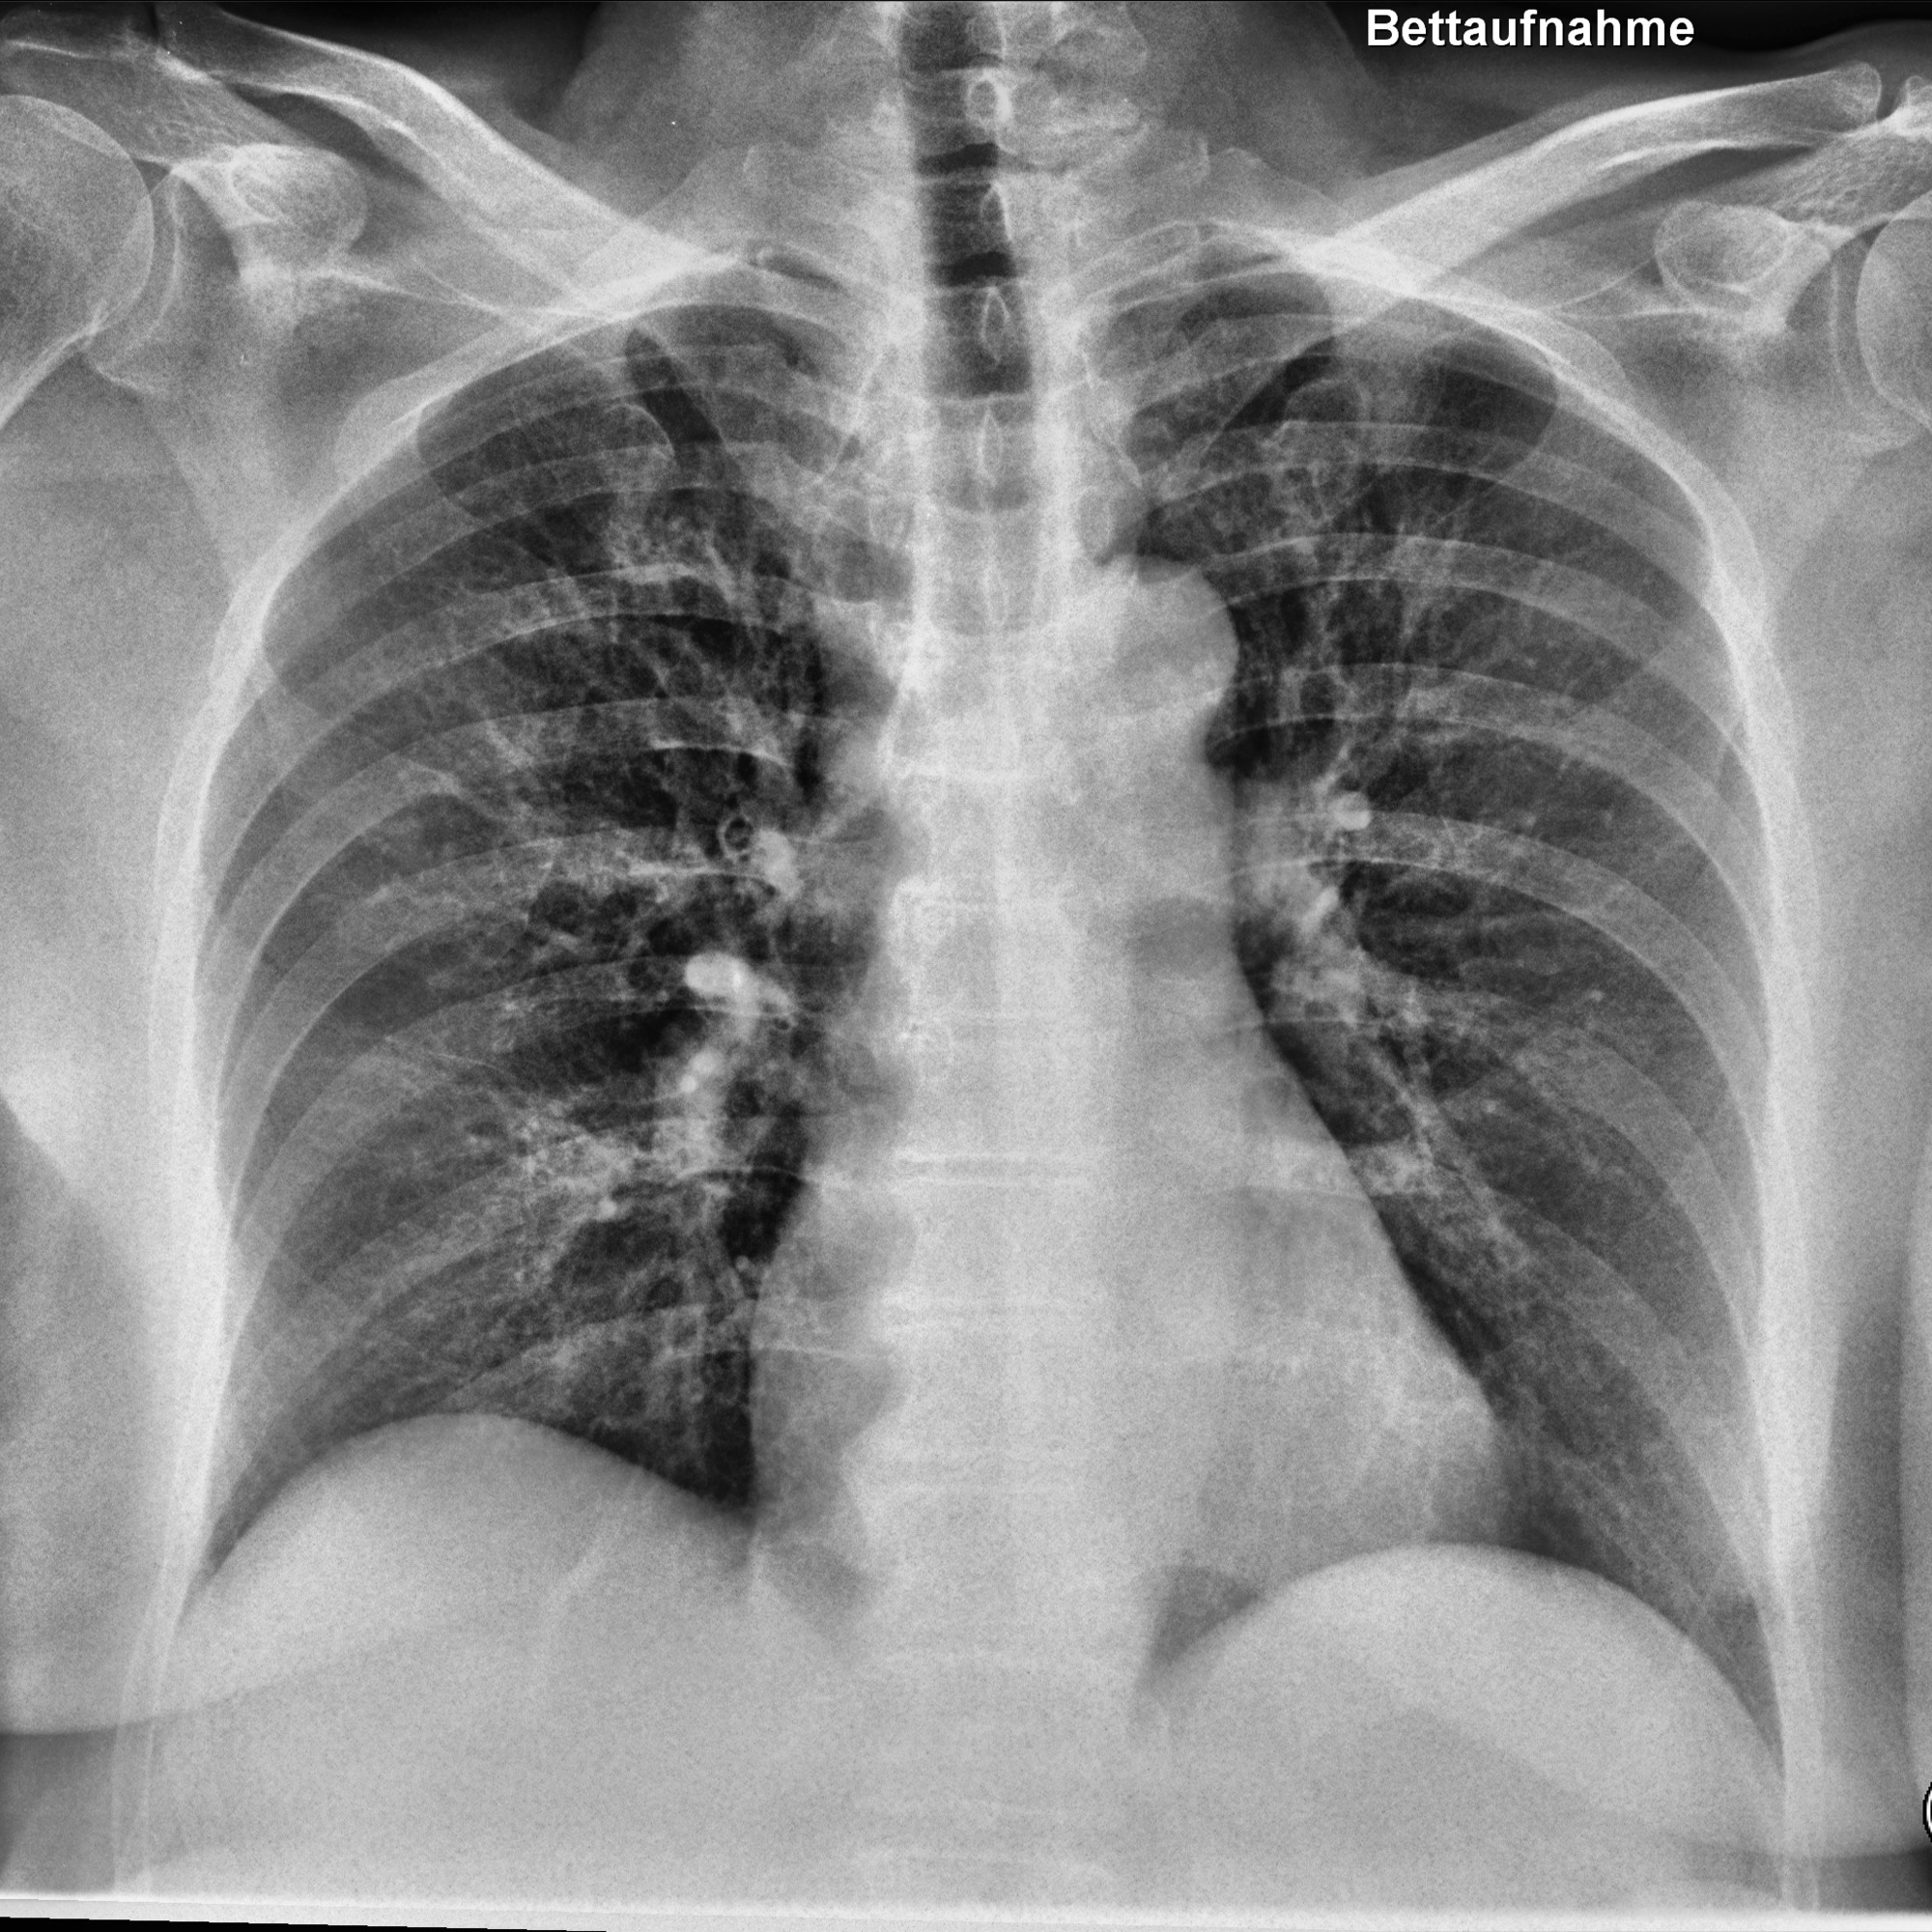

In [16]:
ListofTrainImagePath=list(PathToDataset.glob('data/train/*/*.jpg'))

PIL.Image.open(str(ListofTrainImagePath[25]))

In [7]:
#Defining the Batch Size and the dimension of the input image
batchSize=32
img_height=224
img_width=224

In [ ]:
#Test/Train Splitting stage
train_ds=tf.keras.utils.image_dataset_from_directory(
    PathToDataset.glob('train/*/*.jpg'),
    image_size=(img_height,img_width),
    batch_size=batchSize
)
test_ds=tf.keras.utils.image_dataset_from_directory(
    PathToDataset.glob('test/*/*.jpg'),
    image_size=(img_height,img_width),
    batch_size=batchSize
)


Found 5154 files belonging to 3 classes.
Found 1288 files belonging to 3 classes.


In [ ]:
#Importing all the modules necessary for designing the CNN
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, GlobalAveragePooling2D, Dense, Dropout
from keras.layers.merge import concatenate

In [ ]:
#Defining the Inception Module
def Inception_block(input_layer, f1, f2_conv1, f2_conv3, f3_conv1, f3_conv5, f4): 
  path1 = Conv2D(filters=f1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path2 = Conv2D(filters = f2_conv3, kernel_size = (3,3), padding = 'same', activation = 'relu')(path2)
  path3 = Conv2D(filters = f3_conv1, kernel_size = (1,1), padding = 'same', activation = 'relu')(input_layer)
  path3 = Conv2D(filters = f3_conv5, kernel_size = (5,5), padding = 'same', activation = 'relu')(path3)
  path4 = MaxPooling2D((3,3), strides= (1,1), padding = 'same')(input_layer)
  path4 = Conv2D(filters = f4, kernel_size = (1,1), padding = 'same', activation = 'relu')(path4)
  output_layer = concatenate([path1, path2, path3, path4], axis = -1)
  return output_layer

In [ ]:
def GoogLeNet():
  input_layer = Input(shape = (224, 224, 3))
  X = Conv2D(filters = 64, kernel_size = (7,7), strides = 2, padding = 'valid', activation = 'relu')(input_layer)
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)
  X = Conv2D(filters = 64, kernel_size = (1,1), strides = 1, padding = 'same', activation = 'relu')(X)
  X = Conv2D(filters = 192, kernel_size = (3,3), padding = 'same', activation = 'relu')(X)
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)
  X = Inception_block(X, f1 = 64, f2_conv1 = 96, f2_conv3 = 128, f3_conv1 = 16, f3_conv5 = 32, f4 = 32)
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 192, f3_conv1 = 32, f3_conv5 = 96, f4 = 64)
  X = MaxPooling2D(pool_size= (3,3), strides = 2)(X)
  X = Inception_block(X, f1 = 192, f2_conv1 = 96, f2_conv3 = 208, f3_conv1 = 16, f3_conv5 = 48, f4 = 64)

  # Extra network 1:
  X1 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X1 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X1)
  X1 = Flatten()(X1)
  X1 = Dense(1024, activation = 'relu')(X1)
  X1 = Dropout(0.7)(X1)
  X1 = Dense(3, activation = 'softmax')(X1)

  X = Inception_block(X, f1 = 160, f2_conv1 = 112, f2_conv3 = 224, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)
  X = Inception_block(X, f1 = 128, f2_conv1 = 128, f2_conv3 = 256, f3_conv1 = 24, f3_conv5 = 64, f4 = 64)
  X = Inception_block(X, f1 = 112, f2_conv1 = 144, f2_conv3 = 288, f3_conv1 = 32, f3_conv5 = 64, f4 = 64)

  # Extra network 2:
  X2 = AveragePooling2D(pool_size = (5,5), strides = 3)(X)
  X2 = Conv2D(filters = 128, kernel_size = (1,1), padding = 'same', activation = 'relu')(X2)
  X2 = Flatten()(X2)
  X2 = Dense(1024, activation = 'relu')(X2)
  X2 = Dropout(0.7)(X2)
  X2 = Dense(3, activation = 'softmax')(X2)
  
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)
  X = MaxPooling2D(pool_size = (3,3), strides = 2)(X)
  X = Inception_block(X, f1 = 256, f2_conv1 = 160, f2_conv3 = 320, f3_conv1 = 32, f3_conv5 = 128, f4 = 128)
  X = Inception_block(X, f1 = 384, f2_conv1 = 192, f2_conv3 = 384, f3_conv1 = 48, f3_conv5 = 128, f4 = 128)
  X = GlobalAveragePooling2D(name = 'GAPL')(X)
  X = Dropout(0.4)(X)
  X = Dense(3, activation = 'softmax')(X)
  
  model = Model(input_layer, [X, X1, X2], name = 'GoogLeNet')

  return model

In [ ]:
model=GoogLeNet()

In [ ]:
model.summary()

Model: "GoogLeNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 109, 109, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 54, 54, 64)   0           ['conv2d[0][0]']                 
                                                                                          

In [ ]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
#Training the model
epochs=10
history=model.fit(train_ds, validation_data=test_ds, epochs=epochs)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


162/162 [==============================] - 1410s 9s/step - loss: 2.7747 - dense_4_loss: 0.8735 - dense_1_loss: 0.9949 - dense_3_loss: 0.9063 - dense_4_accuracy: 0.6692 - dense_1_accuracy: 0.6768 - dense_3_accuracy: 0.6768 - val_loss: 1.9282 - val_dense_4_loss: 0.6314 - val_dense_1_loss: 0.6777 - val_dense_3_loss: 0.6190 - val_dense_4_accuracy: 0.7189 - val_dense_1_accuracy: 0.7236 - val_dense_3_accuracy: 0.7283
Epoch 2/10
162/162 [==============================] - 1198s 7s/step - loss: 1.6453 - dense_4_loss: 0.5821 - dense_1_loss: 0.5233 - dense_3_loss: 0.5399 - dense_4_accuracy: 0.7540 - dense_1_accuracy: 0.7800 - dense_3_accuracy: 0.7778 - val_loss: 1.8498 - val_dense_4_loss: 0.6636 - val_dense_1_loss: 0.5594 - val_dense_3_loss: 0.6267 - val_dense_4_accuracy: 0.7803 - val_dense_1_accuracy: 0.8067 - val_dense_3_accuracy: 0.7880
Epoch 3/10
162/162 [==============================] - 1204s 7s/step - loss: 1.2349 - dense_4_loss: 0.4358 - dense_1_loss: 0.3927 - dense_3_loss: 0.4064 - dense

In [ ]:
history.history

{'dense_1_accuracy': [0.6767559051513672,
  0.7799767255783081,
  0.8465269804000854,
  0.8653473258018494,
  0.8942568898200989,
  0.9227784276008606,
  0.9351959824562073,
  0.9414047598838806,
  0.950523853302002,
  0.9377182722091675],
 'dense_1_loss': [0.9948802590370178,
  0.5233425498008728,
  0.3927155137062073,
  0.3600955903530121,
  0.27498501539230347,
  0.21080943942070007,
  0.16913463175296783,
  0.17247982323169708,
  0.14557203650474548,
  0.16950950026512146],
 'dense_3_accuracy': [0.6767559051513672,
  0.7778424620628357,
  0.8420644402503967,
  0.8750485181808472,
  0.8921226263046265,
  0.9239425659179688,
  0.9390764236450195,
  0.9367481470108032,
  0.9468374252319336,
  0.9427629113197327],
 'dense_3_loss': [0.9062920808792114,
  0.5398735404014587,
  0.40638333559036255,
  0.32377883791923523,
  0.2750335931777954,
  0.205757275223732,
  0.17043054103851318,
  0.17884325981140137,
  0.14711597561836243,
  0.16455192863941193],
 'dense_4_accuracy': [0.6691889762

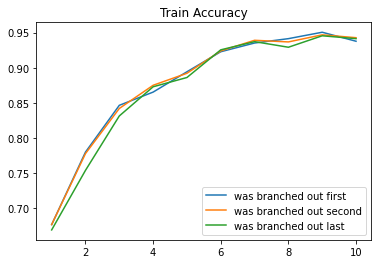

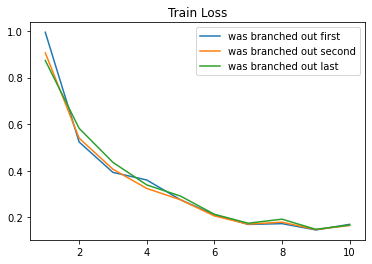

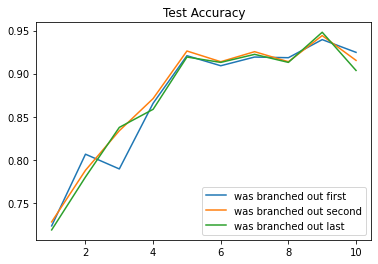

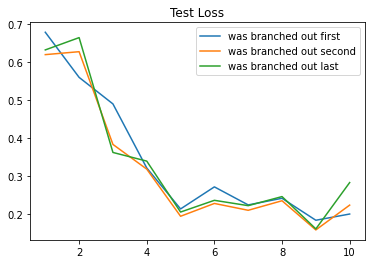

In [ ]:
#Plotting our results
xValues=range(1,epochs+1)


plt.figure()
plt.title("Train Accuracy")
plt.plot(xValues,history.history['dense_1_accuracy'],label='was branched out first')
plt.plot(xValues,history.history['dense_3_accuracy'],label='was branched out second')
#plt.plot(xValues,history.history['dense_17_accuracy'],label='was branched out third')
plt.plot(xValues,history.history['dense_4_accuracy'],label='was branched out last')
plt.legend()
plt.show()



plt.figure()
plt.title("Train Loss")
plt.plot(xValues,history.history['dense_1_loss'],label='was branched out first')
plt.plot(xValues,history.history['dense_3_loss'],label='was branched out second')
#plt.plot(xValues,history.history['dense_17_loss'],label='was branched out third')
plt.plot(xValues,history.history['dense_4_loss'],label='was branched out last')
plt.legend()
plt.show()

plt.figure()
plt.title("Test Accuracy")
plt.plot(xValues,history.history['val_dense_1_accuracy'],label='was branched out first')
plt.plot(xValues,history.history['val_dense_3_accuracy'],label='was branched out second')
#plt.plot(xValues,history.history['val_dense_17_accuracy'],label='was branched out third')
plt.plot(xValues,history.history['val_dense_4_accuracy'],label='was branched out last')
plt.legend()
plt.show()


plt.figure()
plt.title("Test Loss")
plt.plot(xValues,history.history['val_dense_1_loss'],label='was branched out first')
plt.plot(xValues,history.history['val_dense_3_loss'],label='was branched out second')
#plt.plot(xValues,history.history['val_dense_17_loss'],label='was branched out third')
plt.plot(xValues,history.history['val_dense_4_loss'],label='was branched out last')
plt.legend()
plt.show()


